In [1]:
using Pkg
Pkg.activate("/home/ryansenne/PycharmProjects/ssm_julia")

include("/home/ryansenne/PycharmProjects/ssm_julia/src/SSM.jl")
using .SSM
using LinearAlgebra
using Random
using Distributions
using Plots

  Activating project at `~/PycharmProjects/ssm_julia`


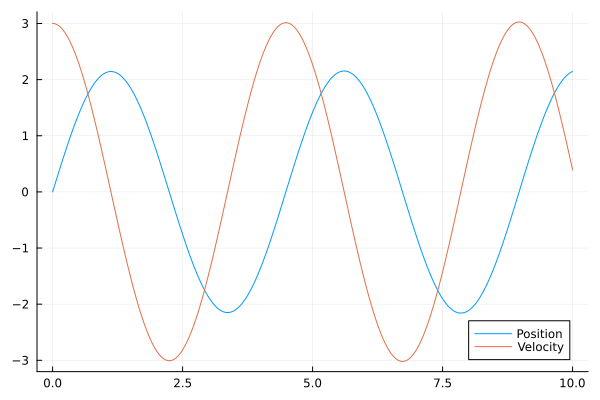

In [2]:
# Generate data from a known linear dynamical system--a pendulum
g = 9.81 # gravity
l = 5.0 # length of pendulum
dt = 0.001 # time step
T = 10.0 # total time
# Discrete-time dynamics
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0; 3.0]
# Time vector
t = 0:dt:T
# Generate data
x = zeros(2, length(t))
x[:,1] = x0
for i = 2:length(t)
    x[:,i] = A*x[:,i-1]
end
# Plot data 
plot(t, x[1,:], label="Position")
plot!(t, x[2,:], label="Velocity")

In [3]:
# Now lets add noise to the system and see if we can recover the dynamics
# Add driving Gaussian noise to simulate observations
x_noisy = zeros(2, length(t))
x_noisy[:, 1] = x0
observation_noise_std = 0.5

noise = rand(Normal(0, observation_noise_std), (2, length(t)))

for i in 2:length(t)
    x_noisy[:, i] = A * x[:, i-1] + noise[:, i]
end

# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 1e-4* I(2)  # Process noise covariance
R = (observation_noise_std^2) * I(2)  # Observation noise covariance
P0 = 0.01 * I(2)  # Initial state covariance
x0 = [0.0; 3.0]  # Initial state mean

# Create the Kalman filter parameter vector
kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, "Gaussian", Vector([true, true, false, true, true, true, true, false]))

# x̂ = SSM.matrix_Kalman_Smoother(kf, x_noisy[:, 1:100]')
# Run the Kalman filter
x_pred, P, v, F, K, ll = KalmanFilter(kf, Matrix{Float64}(x_noisy'))

# Run the smoother
x_smooth, P_smooth, time_cov = KalmanSmoother(kf, Matrix{Float64}(x_noisy'))

([0.27134416999876726 3.1044276217738207; 0.26652167807124993 3.1008717128286727; … ; 2.2288671850794337 0.40038251603066555; 2.229268882961078 0.39600188757330457], [0.01 0.0; 0.009707813600250515 -8.88739135351951e-6; … ; 0.004943276843025833 -0.00011605942097897342; 0.004943276843025833 -0.00011605942097897342;;; 0.0 0.01; -8.887391353519601e-6 0.009707839924703705; … ; -0.00011605942097897277 0.004960462888395258; -0.00011605942097897277 0.004960462888395258], [0.010000000000020428 -1.9620000000872446e-5; 0.009707804712878439 -2.793412163805769e-5; … ; 0.004943160783604855 -0.0001257581301449895; 0.004845360753009993 -0.00012096805448159272;;; 1.0000000000393109e-5 0.010000000000010873; 8.204485715295664e-7 0.009707857361775804; … ; -0.00011109895809057686 0.004960690596979219; -0.00010659924694995876 0.004862209734227723], -14133.915900413784)

In [23]:
ll

-14291.53294909329

In [5]:
SSM.loglikelihood(kf, Matrix{Float64}(x_noisy'))

-14277.909352011598

In [6]:
SSM.loglikelihood_X(x_smooth, kf, x_noisy')

3.770788229383303e8

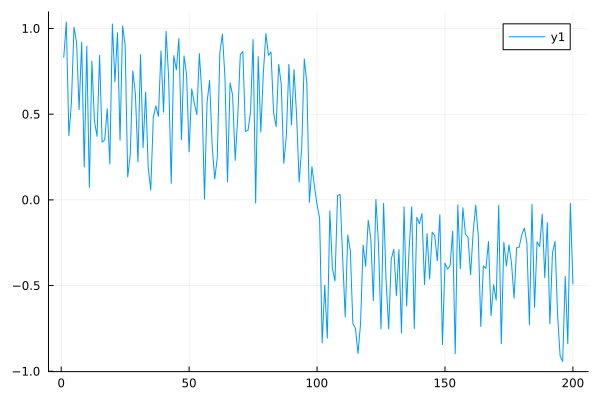

In [50]:
x_test = rand(2, 100)

grad = SSM.∇ₗₗ(x_test', kf, x_noisy[:, 1:100]')
hessian = SSM.∇²ₗₗ(x_test', kf, x_noisy[:, 1:100]')


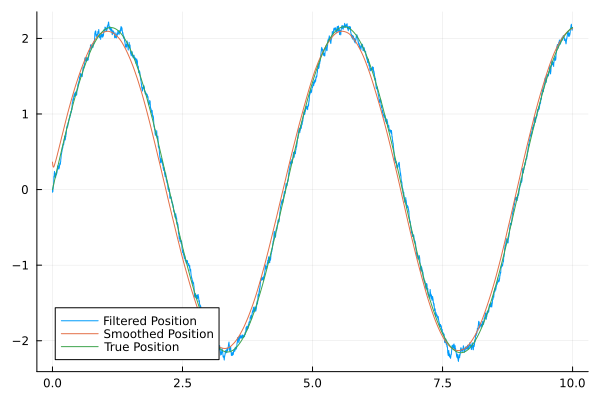

In [28]:
# plot the results
# plot(t, x_noisy[1, :], label="Noisy Position")
plot(t, x_pred[:, 1], label="Filtered Position")
plot!(t, x_smooth[:, 1], label="Smoothed Position")
plot!(t, x[1, :], label="True Position")


In [14]:
# now create a Kalman Filter where we want to learn the parameters
kf_unknown = LDS(; obs_dim=2, latent_dim=2, emissions="Gaussian", fit_bool=[true, true, false, true, true, true, true])


LDS([0.3809586436418617 0.25547315063364284; 0.3396871962237258 0.6734431982353177], [0.721875910796061 0.9199307216123498; 0.9314392636617943 0.17754540836843768], nothing, Bool[1 0; 0 1], Bool[1 0; 0 1], [0.8614299588467548, 0.3452879001067748], [0.1 0.0; 0.0 0.1], nothing, 2, 2, "Gaussian", Bool[1, 1, 0, 1, 1, 1, 1])

In [15]:
SSM.KalmanFilterEM!(kf_unknown, Matrix{Float64}(x_noisy'), 10)

Log-likelihood at iteration 1: -34339.05059937381
Log-likelihood at iteration 2: 

-22839.750552012385


Log-likelihood at iteration 3: -24125.9725562116
Log-likelihood at iteration 4: 

-25866.15820515825


Log-likelihood at iteration 5: -28960.59396021851
Log-likelihood at iteration 6: 

-22945.061628124004


Log-likelihood at iteration 7: -31990.230342314153
Log-likelihood at iteration 8: 

-36374.65330520411


Log-likelihood at iteration 9: -28385.25091578334
Log-likelihood at iteration 10: 

-36074.55868209073


(LDS([1.3314444059506059 0.10465125925838947; -1.0504346899688244 0.6683325879275799], [0.0023730535378234663 0.0007421612050713122; 0.011088736988369874 0.0034978355489254653], nothing, [6132.13781328125 -19344.512348046876; -19344.512348046876 61024.230303125], [1.5200908959144632 -0.36387622297828615; -0.36387622297828615 4.461978050101202], [43.69507179667883, 37.13797294345082], [0.1 0.0; 0.0 0.1], nothing, 2, 2, "Gaussian", Bool[1, 1, 0, 1, 1, 1, 1]), -36074.55868209073)

In [19]:
KalmanFilterOptim!(kf_unknown, x_noisy')


22-element Vector{Float64}:
      1.3314444059506059
     -1.0504346899688244
      0.10465125925838947
      0.6683325879275799
      0.0023730535378234663
      0.011088736988369874
      0.0007421612050713122
      0.0034978355489254653
   6132.13781328125
 -19344.512348046876
      ⋮
     -0.36387622297828615
     -0.36387622297828615
      4.461978050101202
     43.69507179667883
     37.13797294345082
      0.1
      0.0
      0.0
      0.1

In [22]:
SSM.loglikelihood(kf_unknown, Matrix{Float64}(x_noisy'))

-2.8541297253177657e9

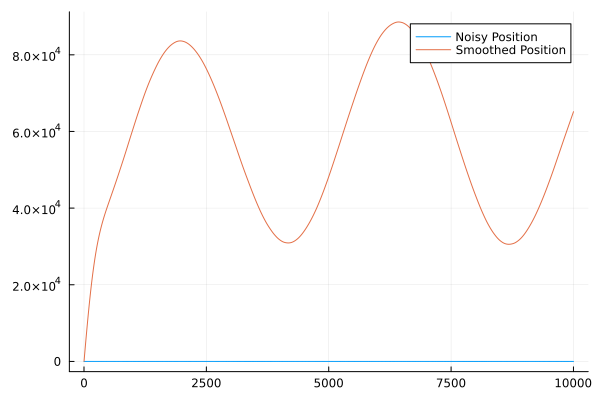

In [21]:
x_smooth_unknown, P_smooth_unknown = KalmanSmoother(kf_unknown, Matrix{Float64}(x_noisy'))

plot(x_noisy[1, :], label="Noisy Position")
plot!(x_smooth_unknown[:, 1], label="Smoothed Position")